In [112]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import math
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [113]:
!pip install emcee
!pip install corner
import emcee

#Ajustar una curva a un modelo de datos

##Generar el modelo probabilístico 

El modelo que va a usar es una lineal recta 

In [114]:
def f_(x,m,b):
  return m*x+b

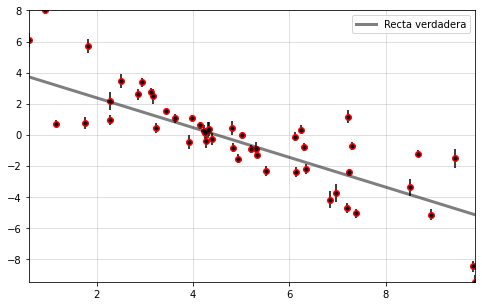

In [115]:
#Parametros 

m=-0.9594                    #pendiente de la recta
b=4.294                      # intersección con el eje y
f=0.534
N=50

#Variables

np.random.seed(123) #inicializar el generador de números pseudoaleatorios

########### Generar muestras aleatorias
rand=np.random.rand(N)     # Arreglo aleatorio de Números entre 0 y 1
randn=np.random.randn(N)   # ""   ""   ""    ""    ""     ""   que tienen una distribución normal 
x=np.sort(10*rand)          # Ordena de menor a mayor los elementos de la lista
y=f_(x,m,b)                     # recta
yerr=0.1+0.5*rand           # barra de errores
y+=np.abs(f*y)*randn 
y+= yerr*randn

# Graficos
plt.figure(figsize=(8,5))
plt.plot(x,y,'ro')
plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0) #Grafica la muetras con su respectivo error
plt.plot(x,f_(x,m,b),'k',alpha=0.5,lw=3,label='Recta verdadera')
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.legend()
plt.grid(alpha=0.5)

# mínimos cuadrados
Existe una recta 
$f(x)=mx+b$, con pendiente $m$, e intersección $b$


Construimos la siguientes matrices
$$y=
\begin{bmatrix}
y_1\\y_2\\\vdots\\y_n
\end{bmatrix}
$$

$$A=
\begin{bmatrix}
1 &x_1\\1 & x_2\\\vdots&\vdots\\1 & x_n
\end{bmatrix}
$$
$$C=
\begin{bmatrix}
\sigma_{y_1}^2&0&\cdots &0\\
0 & \sigma_{y_2}^2&\cdots&0
\\ \vdots&\vdots&&\vdots \\
0& 0& \cdots &\sigma_{y_n}^2
\end{bmatrix}
$$
donde $\sigma^2$ es la varianza de los datos
las constantes $m,b$ se pueden hallar con la siguiente formula



$$
\begin{bmatrix}
b\\m \end{bmatrix}=[A^TC^{-1}A]^{-1}[A^TC^{-1}Y]
$$


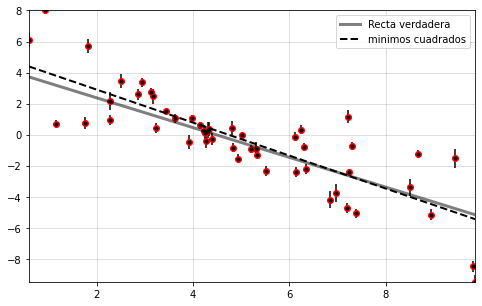

In [116]:
# Matrices
A = np.vander(x, 2)
C = np.diag(yerr * yerr)

# Encontrando la pendiente y la intersección

ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
m1,b1 = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))

# Graficos
plt.figure(figsize=(8,5))
plt.plot(x,y,'ro')
plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0) #Grafica la muestras con su respectivo error
plt.plot(x,f_(x,m,b),'k',alpha=0.5,lw=3,label='Recta verdadera')
plt.plot(x,f_(x,m1,b1),'k--',alpha=1.0,lw=2,label='mínimos cuadrados')
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.legend()
plt.grid(alpha=0.5)

#Estimación de probabilidad máxima

En notación matemática, la función de verosimilitud correcta es:


$$
    \ln\,p(y\,|\,x,\sigma,m,b,f) =
    -\frac{1}{2} \sum_n \left[
        \frac{(y_n-m\,x_n-b)^2}{s_n^2}
        + \ln \left ( 2\pi\,s_n^2 \right )
    \right],
$$

donde

$$
    s_n^2 = \sigma_n^2+f^2\,(m\,x_n+b)^2 \quad .
$$


In [117]:
""" Logaritmo de la probabilidad"""  
def log_likelihood(theta,x,y,sigma):
  m, b, log_f = theta
  sn2=sigma**2+f_(x,m,b)**2*np.exp(2*log_f)
  return -0.5*sum((y-f_(x,m,b))**2/sn2+ np.log(2*np.pi*sn2))
# El logaritmo se debe que la función recibe el logaritmo de f

In [118]:
np.random.seed(42)


nll=lambda *args: -log_likelihood(*args) # Construccion lamda 

#Condiciones iniciales

In=np.array([m,b,np.log(f)])+ 0.1 * np.random.randn(3)

#Solución
Sol=minimize(nll,In,args=(x, y, yerr))
# Extrayendo los valores
m2, b2, log_f2 = Sol.x


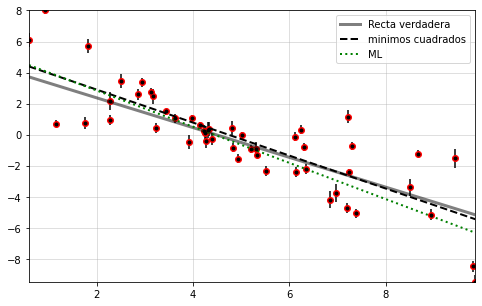

In [119]:
# Gráficos
plt.figure(figsize=(8,5))
plt.plot(x,y,'ro')
plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0) #Grafica la muestras con su respectivo error
plt.plot(x,f_(x,m,b),'k',alpha=0.5,lw=3,label='Recta verdadera')
plt.plot(x,f_(x,m1,b1),'k--',alpha=1.0,lw=2,label='mínimos cuadrados')
plt.plot(x,f_(x,m2,b2),':g',alpha=1.0,lw=2,label='ML')
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.legend()
plt.grid(alpha=0.5)

#Marginalizción e incertidumbre


Generando la posterior multiplicando la función likelihood por una función previa $p(m,b,f)$


$$
    p (m,b,f\,|\,x,y,\sigma) \propto p(m,b,f)\,p(y\,|\,x,\sigma,m,b,f) \quad .
$$



In [120]:
"""función prior"""
# theta es un arreglo con los valores de las contantes m,b,f
def log_p (theta):
  m, b, log_f = theta
  if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
      return 0.0
  return -np.inf


Con ento es podible calcular la probabilidad posterior

In [121]:
# log probabilidad
def log_probability(theta, x, y, yerr):
    lp = log_p(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) # aun nos e porque se suman



# Emcee

In [122]:



pos = Sol.x + 1e-4 * np.random.randn(32, 3)  # posterior ,randn genera 3 arreglos de 32 n umeros aleatorios
nwalkers, ndim = pos.shape # 32 caminos, 3 dimensión 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:08<00:00, 571.47it/s]


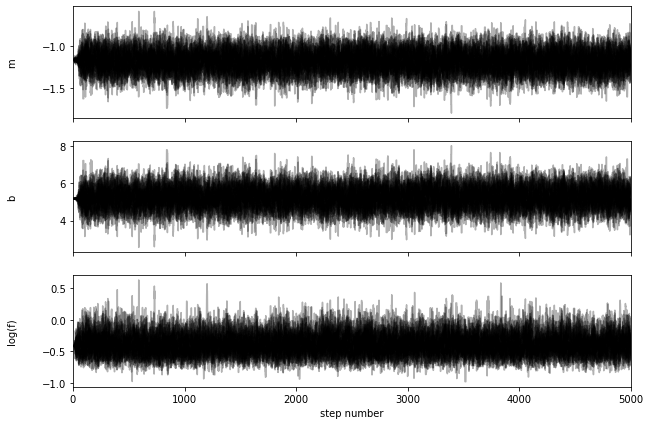

In [124]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain() # arroja un hiper cubo de 1000x32x3
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Echemos un vistazo a lo que ha hecho el muestreador. Un buen primer paso es observar la serie temporal de los parámetros de la cadena. Se puede acceder a las muestras mediante el método: func: EnsembleSampler.get_chain. Esto devolverá una matriz con la forma (5000, 32, 3) dando los valores de los parámetros para cada caminante en cada paso de la cadena. La siguiente figura muestra las posiciones de cada caminante en función del número de pasos en la cadena:

Como se mencionó anteriormente, los caminantes comienzan en pequeñas distribuciones alrededor de los valores de máxima verosimilitud y luego deambulan rápidamente y comienzan a explorar la distribución posterior completa. De hecho, después de menos de 50 pasos, las muestras parecen bastante "quemadas". Esa es una afirmación difícil de hacer cuantitativamente, pero podemos ver una estimación del tiempo de autocorrelación integrado (consulte el tutorial: ref: ʻautocorr` para obtener más detalles):

In [125]:
tau = sampler.get_autocorr_time()
print(tau)

[39.12369418 39.58721484 38.67188855]


Esto sugiere que sólo se necesitan unos 40 pasos para que la cadena "olvide" dónde comenzó. No es descabellado tirar varias veces esta cantidad de pasos como "quemado". Descartemos los 100 pasos iniciales, reduzcamos aproximadamente a la mitad el tiempo de autocorrelación (15 pasos) y aplanémos la cadena para que tengamos una lista plana de muestras:

In [126]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


#Diagrama corner

El gráfico de esquina muestra todas las proyecciones unidimensionales y bidimensionales de las distribuciones de probabilidad posteriores de sus parámetros

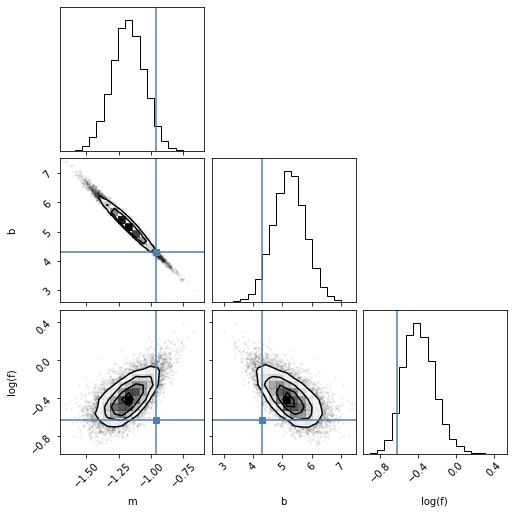

In [127]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

#grafico 
Otro gráfico de diagnóstico es la proyección de sus resultados en el espacio de los datos observados. para este grafico se toman 100 valores de $m$ y de $b$  

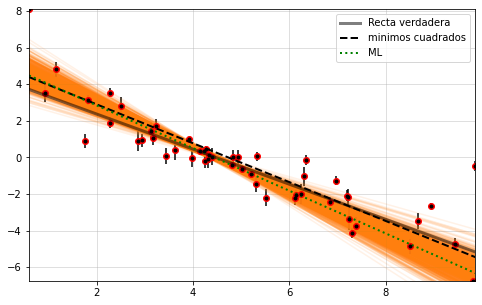

In [166]:
plt.figure(figsize=(8,5))
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.plot(x,y,'ro')
plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0) #Grafica la muetras con su respectivo error
plt.plot(x,f_(x,m,b),'k',alpha=0.5,lw=3,label='Recta verdadera')
plt.plot(x,f_(x,m1,b1),'k--',alpha=1.0,lw=2,label='minimos cuadrados')
plt.plot(x,f_(x,m2,b2),':g',alpha=1.0,lw=2,label='ML')
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.legend()
plt.grid(alpha=0.5)